In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from metpy.plots import SkewT

In [2]:
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_air = xr.open_dataset(
    ncep_url + "pressure/air.mon.1981-2010.ltm.nc", use_cftime=True
)

/home/users/p341cam/miniconda3/envs/venv/lib/python3.11/site-packages/xarray/coding/times.py:167: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


In [3]:
coslat = np.cos(np.deg2rad(ncep_air.lat))
weight = coslat / coslat.mean(dim="lat")
Tobs = (ncep_air.air * weight).mean(dim=("lat", "lon", "time"))

In [4]:
def make_skewT(title=None):
    fig = plt.figure(figsize=(9, 9))
    skew = SkewT(fig, rotation=30)
    skew.plot(
        Tobs.level,
        Tobs,
        color="black",
        linestyle="-",
        linewidth=2,
        label="Observations",
    )
    skew.ax.set_ylim(1050, 10)
    skew.ax.set_xlim(-90, 45)

    skew.plot_dry_adiabats(linewidth=0.5)
    skew.plot_moist_adiabats(linewidth=0.5)

    skew.ax.legend()
    skew.ax.set_xlabel("Temperature [$\degree$C]", fontsize=14)
    skew.ax.set_ylabel("Pressure [hPa]", fontsize=14)
    if title:
        skew.ax.set_title(title)

    return skew

In [5]:
def add_profile(skew, model, linestyle="-", color=None):
    line = skew.plot(
        model.lev,
        model.Tatm - climlab.constants.tempCtoK,
        label=model.name,
        linewidth=2,
    )[0]
    skew.plot(
        1000,
        model.Ts - climlab.constants.tempCtoK,
        "o",
        markersize=8,
        color=line.get_color(),
    )
    skew.ax.legend()

In [6]:
cesm_data_path = "http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/"
atm_control = xr.open_dataset(
    cesm_data_path + "cpl_1850_f19/concatenated/cpl_1850_f19.cam.h0.nc"
)

In [7]:
weight_factor = atm_control.gw / atm_control.gw.mean(dim="lat")
Qglobal = (atm_control.Q * weight_factor).mean(dim=("lat", "lon", "time"))

In [8]:
import climlab

state = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)

rad = climlab.radiation.RRTMG(
    name="Radiation (all gases)",  # give our model a name!
    state=state,  # give our model an initial condition!
    specific_humidity=Qglobal.values,  # tell the model how much water vapor there is
    albedo=0.25,  # this the SURFACE shortwave albedo
    timestep=climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
)

In [9]:
rad_noO3 = climlab.process_like(rad)
rad_noO3.absorber_vmr["O3"] *= 0.0
rad_noO3.name = "no O3"

rad_noH2O = climlab.process_like(rad)
rad_noH2O.specific_humidity *= 0.0
rad_noH2O.name = "no H2O"

rad_noO3_noH2O = climlab.process_like(rad_noO3)
rad_noO3_noH2O.specific_humidity *= 0.0
rad_noO3_noH2O.name = "no O3, no H2O"

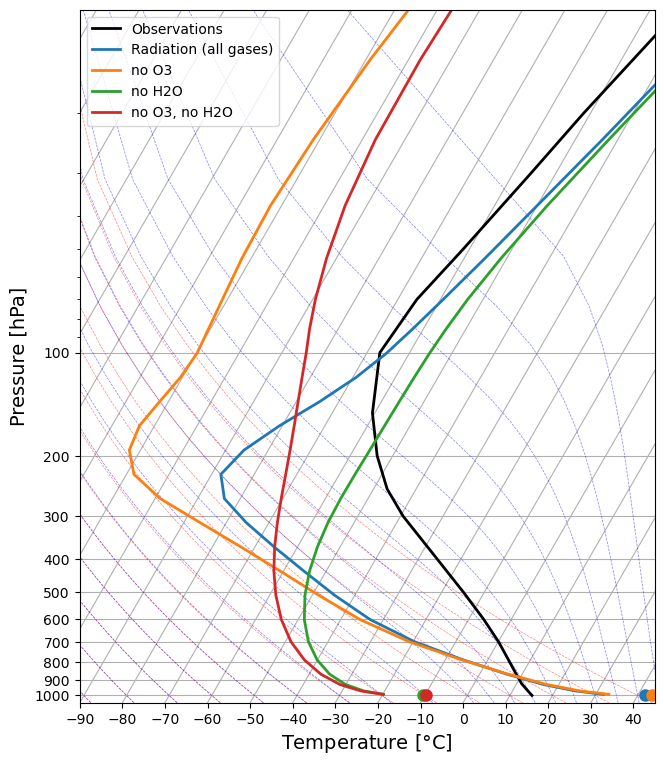

In [10]:
rad_models = [rad, rad_noO3, rad_noH2O, rad_noO3_noH2O]

for model in rad_models:
    for n in range(100):
        model.step_forward()
    while np.abs(model.ASR - model.OLR) > 0.01:
        model.step_forward()

skew = make_skewT()
for model in rad_models:
    add_profile(skew, model)

In [11]:
state = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)

rad = climlab.radiation.RRTMG(
    name="Radiation (net)",
    state=state,
    specific_humidity=Qglobal.values,
    timestep=climlab.constants.seconds_per_day,
    albedo=0.25,  # surface albedo, tuned to give reasonable ASR for reference cloud-free model
)

conv = climlab.convection.ConvectiveAdjustment(
    name="Convection",
    state=state,
    adj_lapse_rate=6.5,  # this is the key parameter! We'll discuss below
    timestep=rad.timestep,  # same timestep!
)

rcm = climlab.couple([rad, conv], name="RCE Model")

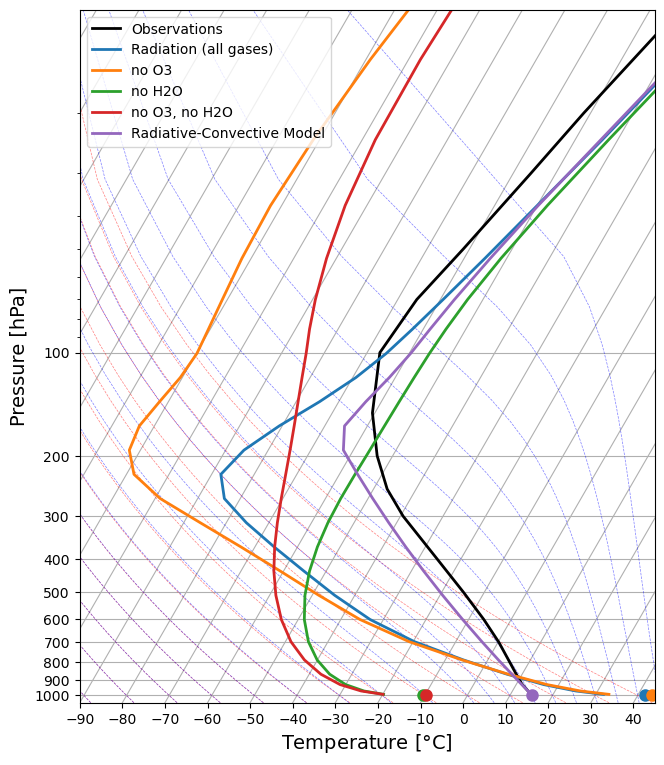

In [12]:
rcm_models = [rcm]

for model in rcm_models:
    for n in range(100):
        model.step_forward()
    while np.abs(model.ASR - model.OLR) > 0.01:
        model.step_forward()

skew2 = make_skewT()
for model in rad_models:
    add_profile(skew2, model)
for model in rcm_models:
    add_profile(skew2, model)